In [1]:
import os
from config import config
from notebook_utils import log_query_and_results
from dataloader import get_random_item, get_item
from augmentation import Augmentation
from aws.opensearch import OpenSearchWrapper
from aws.embedding import BedrockEmbedding
from utils import encode_image_base64, encode_image_base64_from_file

---

# Vector Search 테스트

Multimodal Embedding, Text Embedding 별로 검색 성능을 확인하기 위해 아래와 같은 케이스에 대해 테스트 합니다.

### Embedding Case

1. Query를 항상 Multimodal Embedding (`search_multimodal`)
2. Query를 항상 Text Embedding (`search_text`)
3. Query가 텍스트인 경우 Text Embedding, 이미지를 포함한 경우 Multimodal Embedding (`search_hybrid`)

### Test Scenario

1. 영문 text 쿼리로 검색 했을 때
2. 한글 text 쿼리로 검색 했을 때
3. 이미지 쿼리로 검색했을 때


In [2]:
embedding = BedrockEmbedding()

osImage = OpenSearchWrapper(
    endpoint=config.OPENSEARCH_ENDPOINT,
    index=config.OPENSEARCH_INDEX_IMAGE,
    region=config.OPENSEARCH_REGION
)

osText = OpenSearchWrapper(
    endpoint=config.OPENSEARCH_ENDPOINT,
    index=config.OPENSEARCH_INDEX_TEXT,
    region=config.OPENSEARCH_REGION
)

osImage.client.ping()

True

In [3]:
@log_query_and_results
def search_multimodal(text: str = None, image: str = None):
    vector = embedding.embedding_multimodal(text=text, image=image)
    docs = osImage.vector_search(vector=vector)
    return docs

@log_query_and_results
def search_text(text: str = None, image: str = None):
    if image:
        text = Augmentation().describe_image(image=image)
        print(text)
    vector = embedding.embedding_text(text=text)
    docs = osText.vector_search(vector=vector)
    return docs

def search_hybrid(text: str = None, image: str = None):
    if image:
        docs = search_multimodal(text=text, image=image)
        return docs
    if text:
        docs = search_text(text=text, image=image)
        return docs
    return []


---

### 1. Query를 항상 Multimodal Embedding

```mermaid
graph LR
    A[\image\]:::imageStyle
    E[\text\]:::descStyle

    A --> F[[Multimodal Embedding]]:::multiEmbeddingStyle
    E --> F[[Multimodal Embedding]]:::multiEmbeddingStyle

    F --> H[(product-image)]:::outputStyle
    
    classDef imageStyle fill:#B090F3,stroke:#E6E6FA,stroke-width:2px,color:#000000;
    classDef descStyle fill:#87CAF0,stroke:#E6E6FA,stroke-width:2px,color:#000000;
    classDef multiEmbeddingStyle fill:#FFA500,stroke:#F08D2B,stroke-width:2px,color:#000000;
    classDef outputStyle fill:#F08D2B,stroke:#FFFFFF,stroke-width:2px,color:#000000;
```

- 영문으로 검색 했을 경우, text로 검색해도 관련 image가 잘 검색됩니다.
- 한글로 검색 했을 경우, 연관된 데이터를 제대로 검색하지 못합니다.
  - multimodal embedding 모델은 주로 영어 데이터를 기반으로 학습되어 있어, 한글 텍스트와 관련된 이미지의 관계를 제대로 이해하지 못합니다.
- 이미지로 검색 했을 경우, 시각적으로 비슷한 아이템들이 검색됩니다.

======= Query ========
red t-shirt with Emirates on it
======= Results ========


id,embedType,thumbnail,page_content,score
18634,image-namekor,,푸마 남성 GP 버드 로고 레드 티셔츠,0.652676
6577,image-namekor,,나이키 남성 아스널 홈 스타디움 레드 저지,0.650009
9958,image-namekor,,나이키 남성 아스날 SS 트레이닝 레드 저지,0.647333
9958,image,,이미지는 빨간색 폴리에스터 소재의 나이키 아스날 축구 유니폼을 보여주고 있습니다. 흰색 소매와 대각선 패턴이 특징이며 아스날 클럽 로고와 'Fly Emirates' 문구가 새겨져 있습니다.,0.647053
18634,image,,이미지는 레드 컬러의 반팔 티셔츠를 착용한 남성 모델을 보여주고 있습니다. 티셔츠 앞면에는 푸마 브랜드의 로고 그래픽이 프린트되어 있습니다. 소재는 면 100%로 보입니다.,0.646363
6577,image,,"이미지는 레드 컬러의 라운드 넥 티셔츠로 흰색 넥라인 테두리, 왼쪽 가슴에 아스널 로고 자수, 가슴 프린트, 흰색 소매, 오른쪽 가슴에 나이키 스우시가 있습니다.",0.644772

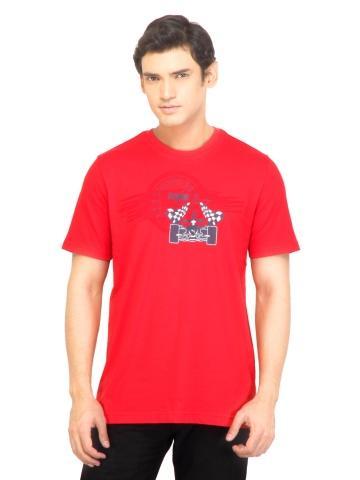
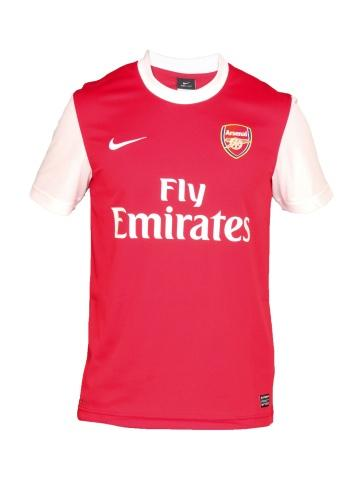
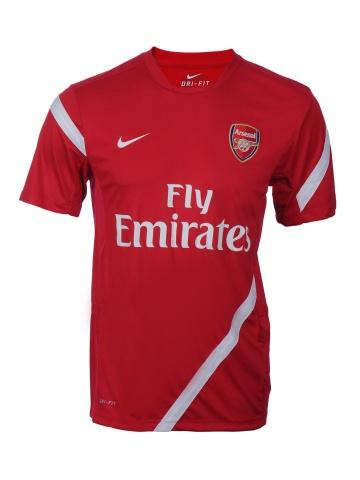
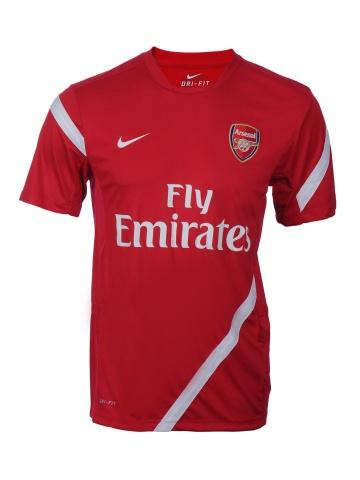
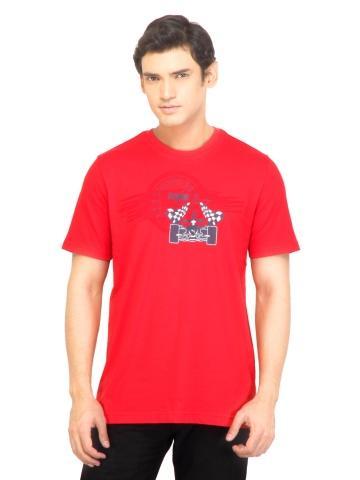
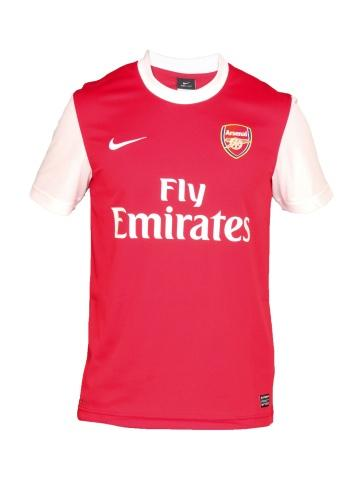

In [5]:
_ = search_multimodal(text="red t-shirt with Emirates on it")

======= Query ========
watch
======= Results ========


id,embedType,thumbnail,page_content,score
43167,image-namekor,,패스트랙 여성 보라색 다이얼 시계,0.708931
10131,image-namekor,,에스프리트 여성 로만 브라운 스틸 시계,0.708109
43190,image-namekor,,패스트랙 여성 화이트 다이얼 시계,0.705833
23268,image-namekor,,맥시마 스틸 남성 블루 시계,0.701784
29415,image-namekor,,지오다노 남성 화이트 다이얼 시계,0.700113
11639,image-namekor,,푸마 남성 플럭스 L 블랙 시계,0.686262

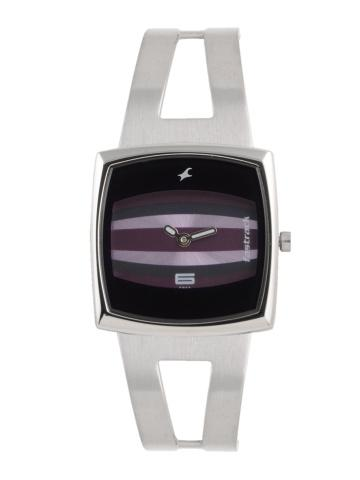
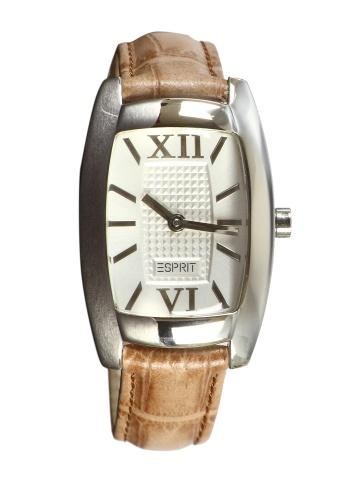
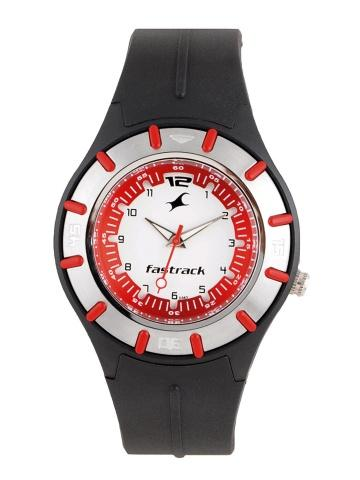
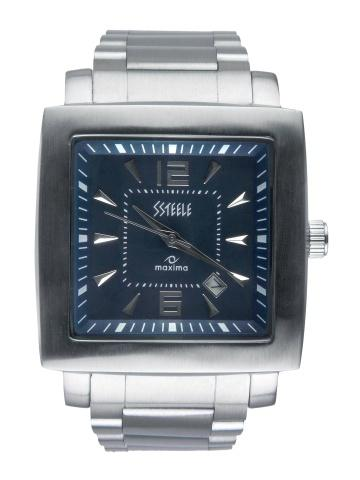
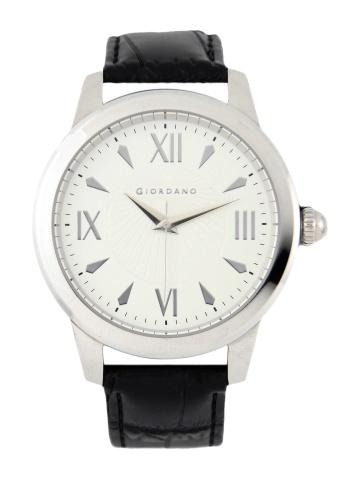
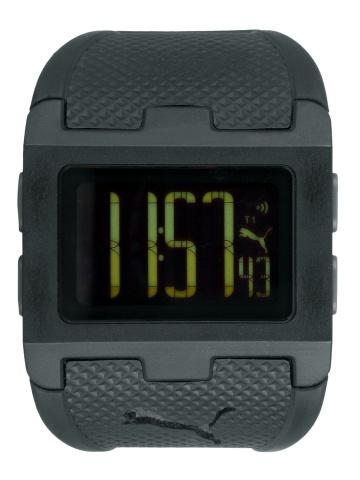

In [4]:
_ = search_multimodal(text='watch')

======= Query ========
시계
======= Results ========


id,embedType,thumbnail,page_content,score
43915,image-namekor,,페멜라 여성 크림 반바지,0.843263
48090,image-namekor,,프렌치 커넥션 여성 올리브 탑,0.842965
51482,image-namekor,,데니즌 남성 블루 진,0.842599
57042,image-namekor,,엘 블랙 드레스,0.842553
31913,image-namekor,,파빈디아 여성 핑크 슬링백,0.841382
32208,image-namekor,,파빈디아 여성 오렌지 쿠르타,0.840659

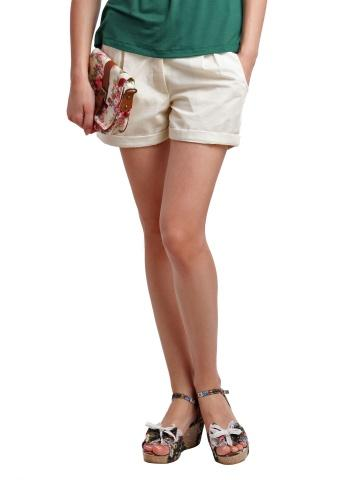
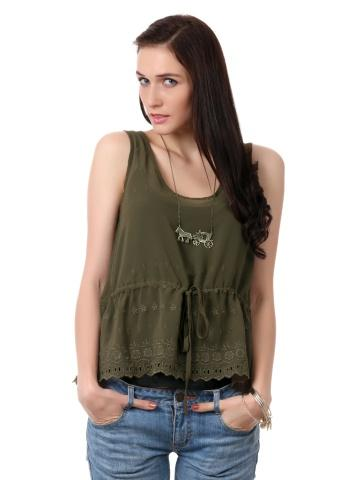
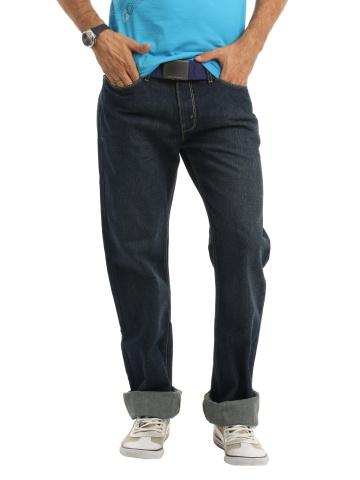
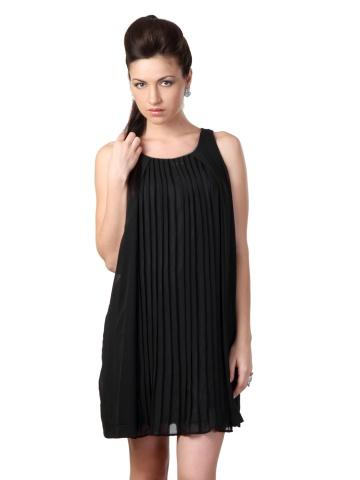
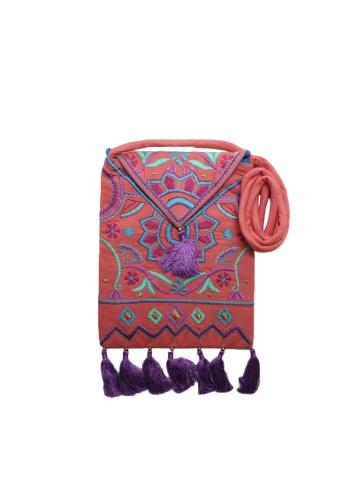
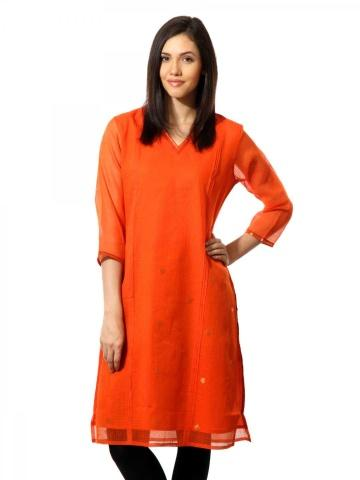

In [52]:
_ = search_multimodal(text='시계')

======= Query ========
None



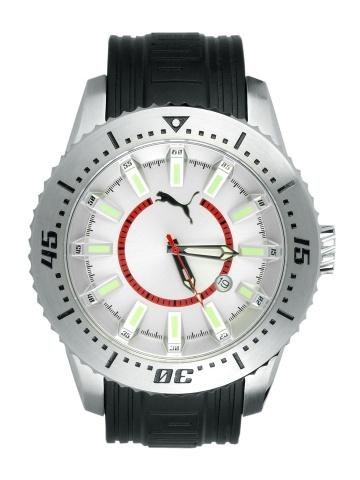

======= Results ========


id,embedType,thumbnail,page_content,score
43190,image,,이 이미지는 블랙 실리콘 밴드에 화이트 다이얼과 레드 포인터가 있는 스포티한 디자인의 아날로그 쿼츠 시계를 보여줍니다. 다이얼 주변에는 레드 베젤이 있어 시계에 포인트를 더합니다.,0.799584
53589,image,,"이 이미지는 스테인리스 스틸 소재의 원형 케이스와 블랙 다이얼, 화이트 및 블랙 바늘, 그리고 스틸 스트랩으로 구성된 Q&Q 브랜드의 남성용 아날로그 시계를 보여주고 있습니다. 다이얼에는 노란색 액센트가 있어 스포티한 느낌을 더합니다.",0.765911
32350,image,,이 이미지는 스테인리스 스틸 소재의 은색 밴드와 베젤이 있는 아날로그 시계를 보여주고 있습니다. 다이얼은 블랙 컬러이며 아라비아 숫자와 바 인덱스가 있습니다. 베젤에는 회전 베젤이 있어 시간 측정이 가능합니다.,0.764429
43190,image-namekor,,패스트랙 여성 화이트 다이얼 시계,0.757479
53589,image-namekor,,Q&Q 남성 블랙 다이얼 시계,0.737743
29415,image,,"이미지는 블랙 가죽 밴드에 스테인리스 스틸 라운드 케이스, 화이트 다이얼, 로마 숫자 시간 표시가 있는 클래식한 남성 아날로그 시계를 보여줍니다.",0.737140

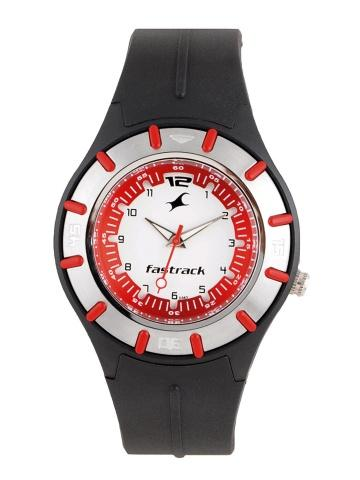
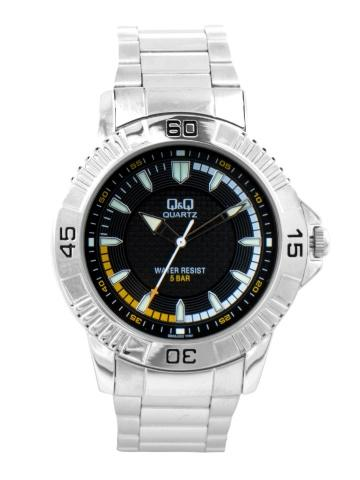
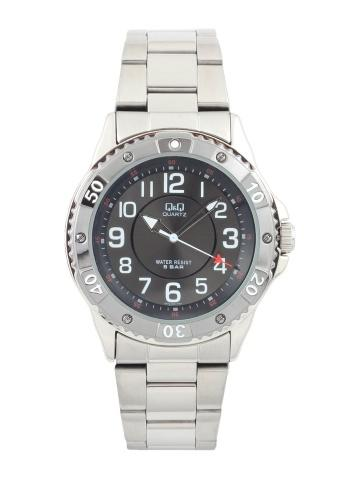
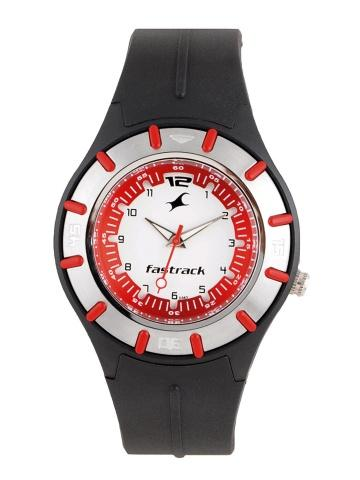
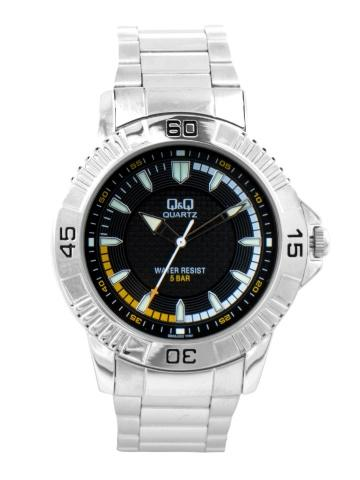
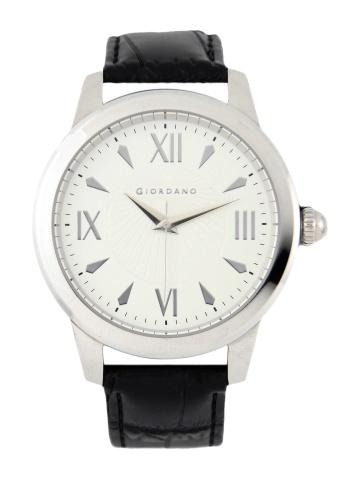

In [8]:
item = get_item('11646')
image = encode_image_base64(item['thumbnail'])
_ = search_multimodal(image=image)

---

### 2. Query를 항상 Text Embedding

```mermaid
graph LR
    A[/image/]:::imageStyle
    E[/text/]:::descStyle

    A --> F([Multimodal LLM]):::llmStyle
    F --> G[[Text Embedding]]:::multiEmbeddingStyle
    E --> G[[Text Embedding]]:::textEmbeddingStyle

    G --> I[(product-text)]:::outputStyle

    classDef imageStyle fill:#B090F3,stroke:#E6E6FA,stroke-width:2px,color:#000000;
    classDef descStyle fill:#87CAF0,stroke:#E6E6FA,stroke-width:2px,color:#000000;
    classDef llmStyle fill:#FFABAB,stroke:#E6E6FA,stroke-width:2px,color:#000000;
    classDef textEmbeddingStyle fill:#FFE451,stroke:#F08D2B,stroke-width:2px,color:#000000;
    classDef outputStyle fill:#F08D2B,stroke:#FFFFFF,stroke-width:2px,color:#000000;
```

- 영문/한글로 검색 했을 때 모두 관련된 데이터가 잘 검색됩니다.
  - text embedding 모델은 multimodal embedding에 비해 더 많은 언어에 대해 방대하게 학습이 되어있습니다.
- 이미지를 쿼리하기 위해서는, Multimodal LLM을 통해 이미지를 해석하고, 해석한 text 데이터를 입력으로 넣습니다.

======= Query ========
red t-shirt with Emirates on it
======= Results ========


id,embedType,thumbnail,page_content,score
4861,text-imgdesc,,이 이미지는 노란색 바탕에 붉은색 트리밍이 있는 축구 유니폼 저지를 보여주고 있습니다. 앞면에는 아스날 팀 로고와 'Fly Emirates' 스폰서 로고가 새겨져 있습니다. 소재는 Dri-Fit 100% 재활용 폴리에스터로 제작되었습니다.,0.594116
9958,text-imgdesc,,이미지는 빨간색 폴리에스터 소재의 나이키 아스날 축구 유니폼을 보여주고 있습니다. 흰색 소매와 대각선 패턴이 특징이며 아스날 클럽 로고와 'Fly Emirates' 문구가 새겨져 있습니다.,0.591377
9958,text,,"Nike Men Arsenal Ss Tr Red Jersey 나이키 남성 아스날 SS 트레이닝 레드 저지 축구 팬들을 위한 완벽한 선물, 나이키 아스날 트레이닝 져지! 열정적인 아스날 팬이라면 이 제품을 절대 놓치면 안 됩니다. 나이키에서 선보인 이 아스날 트레이닝 져지는 팀의 전통적인 레드 컬러와 화이트 슬리브로 디자인되어 아스날의 정체성을 고스란히 담고 있습니다. 뛰어난 기능성도 자랑합니다. Dri-FIT 기술이 적용되어 운동 중 발생하는 땀을 빠르게 배출해 쾌적한 착용감을 선사합니다. 또한 측면 메쉬 패널이 통풍성을 높여 시원함을 더합니다. 환경 보호에도 힘썼습니다. 이 져지는 재활용 플라스틱 병 8개 분량으로 만들어져 지구 환경 보호에 동참하고 있죠. 아스날의 팬심과 스타일, 기능성을 모두 만족시키는 나이키 아스날 트레이닝 져지를 지금 바로 만나보세요!",0.586347
5719,text,,"Basics Men Green Academy Football League T-shirt 베이식스 남성 녹색 아카데미 축구 리그 티셔츠 여름 날씨에 멋진 스타일을 완성하세요! 베이식스의 이 녹색과 갈색 스트라이프 티셔츠는 캐주얼한 분위기를 연출하면서도 스타일리시한 룩을 완성해줄 것입니다. 100% 순면 소재로 제작되어 쾌적하고 건조한 착용감을 선사하며, 폴로 넥 디자인과 러플 장식의 버튼 플라켓이 세련된 디테일을 더합니다. 가슴 부분의 어플리케 워크와 스티치 디테일이 독특한 매력을 가미했습니다. 이 티셔츠를 멋진 청바지나 치노 팬츠와 매치하고 마인트라의 다양한 신발 컬렉션으로 포인트를 주면 완벽한 캐주얼 웨어 룩이 완성됩니다. 브런치 데이트, 친구 모임 등 다양한 일상 속에서 활용하실 수 있을 것입니다. 지금 바로 주문하세요!",0.584307
11781,text-imgdesc,,이미지는 회색 반팔 티셔츠를 입은 남성 모델을 보여주고 있습니다. 티셔츠 앞면에는 'COLLEGE HOFF EST.1983'라는 프린트 디자인과 로고가 있습니다. 티셔츠는 캐주얼한 스타일입니다.,0.582851
58381,text-imgdesc,,"이 이미지는 남성 모델이 입은 진회색 반팔 티셔츠를 보여줍니다. 티셔츠에는 원형 로고와 'ONE,909', 'LM' 등의 텍스트 그래픽이 프린트되어 있습니다.",0.581507

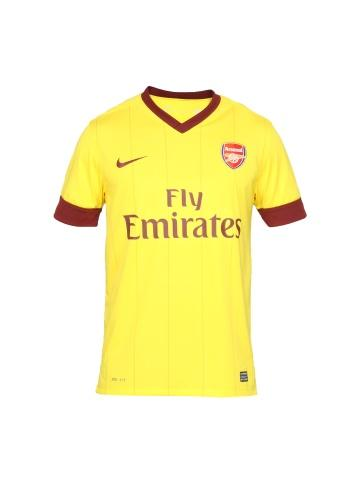
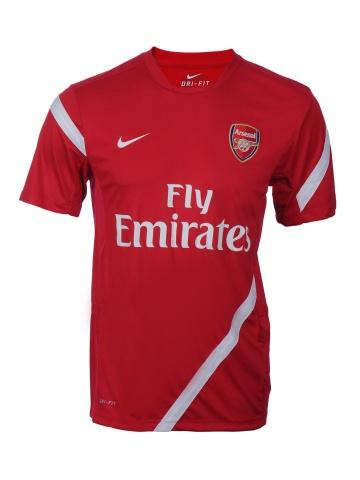
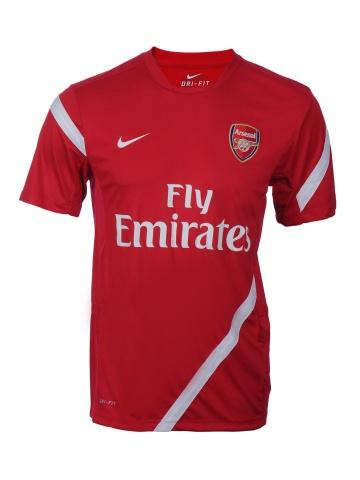
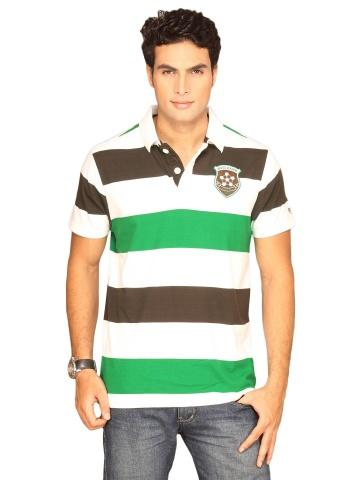
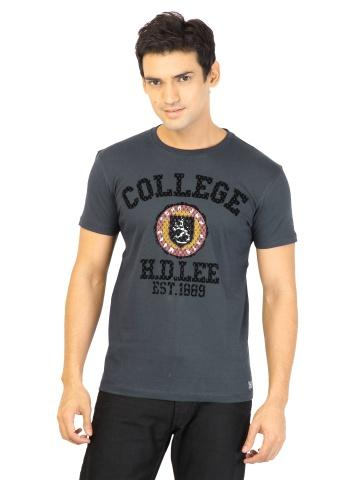
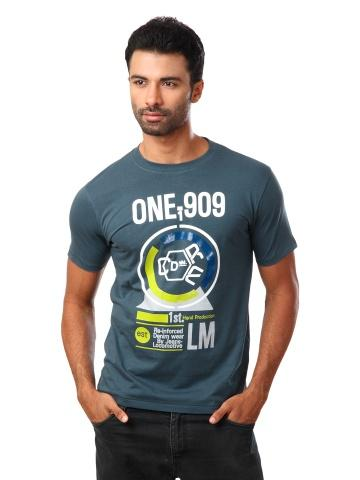

In [6]:
_ = search_text(text="red t-shirt with Emirates on it")

======= Query ========
watch
======= Results ========


id,embedType,thumbnail,page_content,score
11639,text-summary,,이 이미지는 검은색 플라스틱 케이스와 고무 스트랩으로 이루어진 디지털 시계를 보여줍니다. 직사각형 모양의 디스플레이에는 녹색 숫자로 시간이 표시되어 있습니다. 전체적으로 스포티하고 실용적인 디자인입니다.,0.571049
53589,text-summary,,"이 이미지는 스테인리스 스틸 소재의 원형 케이스와 블랙 다이얼, 화이트 및 블랙 바늘, 그리고 스틸 스트랩으로 구성된 Q&Q 브랜드의 남성용 아날로그 시계를 보여주고 있습니다. 다이얼에는 노란색 액센트가 있어 스포티한 느낌을 더합니다.",0.570546
33887,text,,"Citizen Men Black Dial Eco-Drive Watch AW1040-56E, 시티즌 남성 블랙 다이얼 에코 드라이브 시계 AW1040-56E, Men 용으로 Adults-Men 대상으로 2016년도에 Citizen 브랜드에서 출시된 제품 입니다. Winter에 착용 하기 좋은 아이템 입니다. 분류는 Accessories 입니다. 가격은 1090000원 입니다. 이 제품은 스테인리스 스틸 소재의 아날로그 시계로, 블랙 다이얼과 실버 톤 브레이슬릿 스트랩을 갖추고 있습니다. 블랙 실버 스테인리스스틸 아날로그 브레이슬릿 회전베젤 에코드라이브",0.567282
23268,text-summary,,이미지는 스테인리스 스틸 소재의 정사각형 남성용 아날로그 시계를 보여주고 있습니다. 다이얼은 블루 컬러이며 로마 숫자와 바늘이 있습니다. 스틸 밴드가 있고 케이스 측면에 나사가 있어 시간 조절이 가능해 보입니다.,0.565937
43190,text-summary,,이 이미지는 블랙 실리콘 밴드에 화이트 다이얼과 레드 포인터가 있는 스포티한 디자인의 아날로그 쿼츠 시계를 보여줍니다. 다이얼 주변에는 레드 베젤이 있어 시계에 포인트를 더합니다.,0.565877
33887,text-summary,,"이미지는 스테인리스 스틸 소재의 원형 케이스와 블랙 다이얼, 실버 톤 브레이슬릿 스트랩을 갖춘 아날로그 시계를 보여주고 있습니다. 다이얼에는 시간 표시 마커와 날짜 창이 있으며, 회전 베젤이 있는 스포티한 디자인입니다.",0.564538

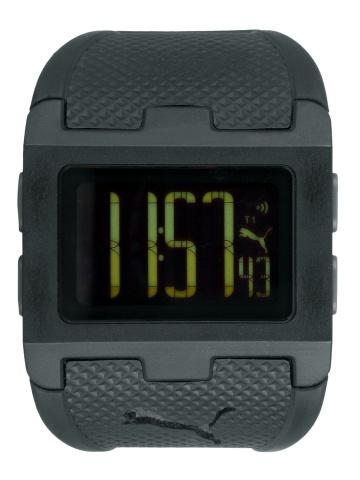
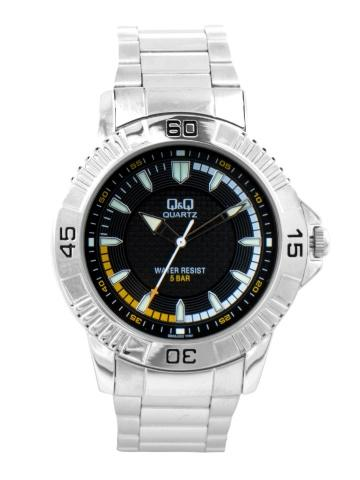
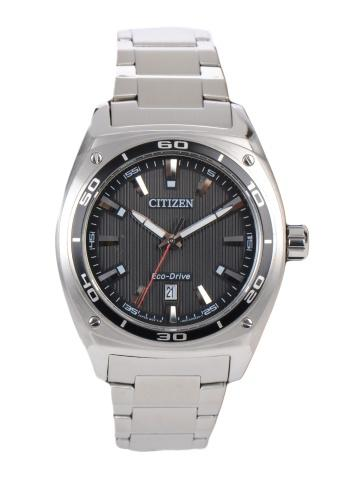
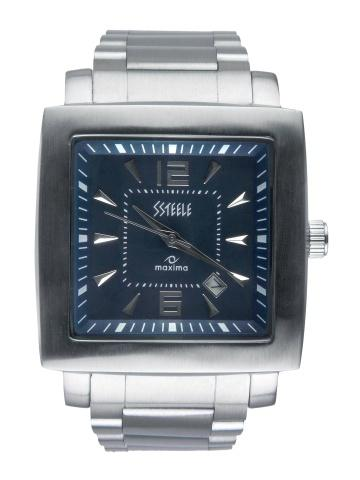
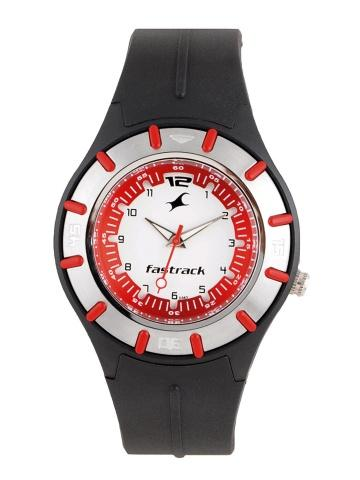
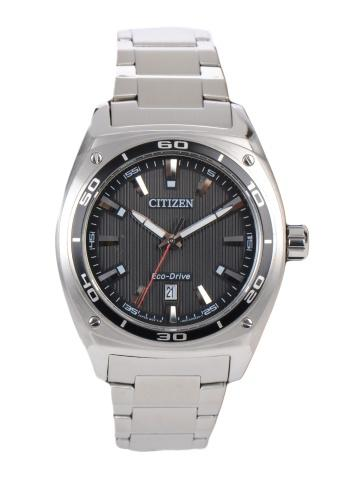

In [54]:
_ = search_text(text='watch')

======= Query ========
시계
======= Results ========


id,embedType,thumbnail,page_content,score
11639,text-summary,,이 이미지는 검은색 플라스틱 케이스와 고무 스트랩으로 이루어진 디지털 시계를 보여줍니다. 직사각형 모양의 디스플레이에는 녹색 숫자로 시간이 표시되어 있습니다. 전체적으로 스포티하고 실용적인 디자인입니다.,0.575755
43190,text-summary,,이 이미지는 블랙 실리콘 밴드에 화이트 다이얼과 레드 포인터가 있는 스포티한 디자인의 아날로그 쿼츠 시계를 보여줍니다. 다이얼 주변에는 레드 베젤이 있어 시계에 포인트를 더합니다.,0.562858
23268,text-summary,,이미지는 스테인리스 스틸 소재의 정사각형 남성용 아날로그 시계를 보여주고 있습니다. 다이얼은 블루 컬러이며 로마 숫자와 바늘이 있습니다. 스틸 밴드가 있고 케이스 측면에 나사가 있어 시간 조절이 가능해 보입니다.,0.560405
53589,text-summary,,"이 이미지는 스테인리스 스틸 소재의 원형 케이스와 블랙 다이얼, 화이트 및 블랙 바늘, 그리고 스틸 스트랩으로 구성된 Q&Q 브랜드의 남성용 아날로그 시계를 보여주고 있습니다. 다이얼에는 노란색 액센트가 있어 스포티한 느낌을 더합니다.",0.558292
33887,text-summary,,"이미지는 스테인리스 스틸 소재의 원형 케이스와 블랙 다이얼, 실버 톤 브레이슬릿 스트랩을 갖춘 아날로그 시계를 보여주고 있습니다. 다이얼에는 시간 표시 마커와 날짜 창이 있으며, 회전 베젤이 있는 스포티한 디자인입니다.",0.557206
43167,text-summary,,이미지는 사각형 케이스에 검은색과 보라색 스트라이프 무늬의 다이얼을 가진 은색 메탈 밴드 시계를 보여주고 있습니다. 다이얼에는 시침과 분침이 있으며 케이스 윗부분에 작은 별 모양의 장식이 있습니다.,0.556477

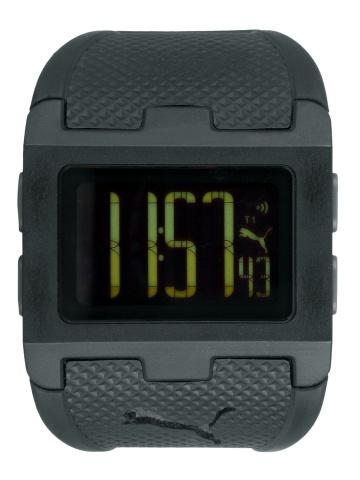
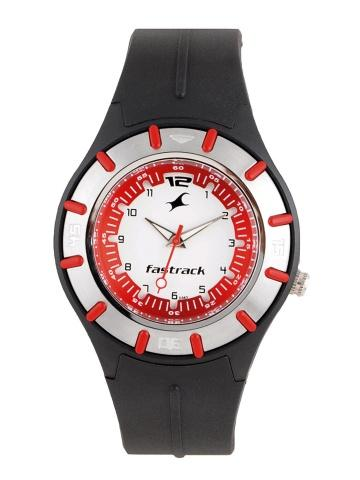
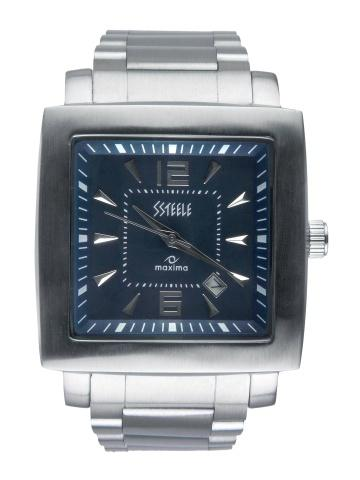
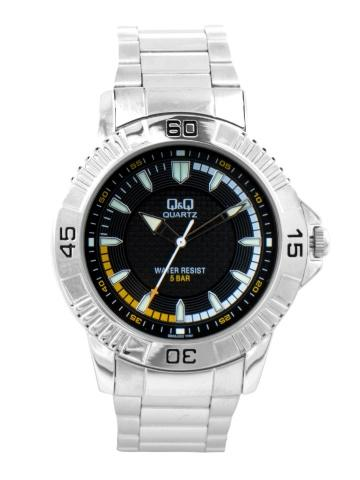
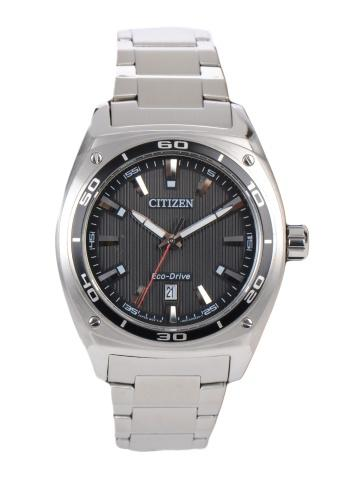
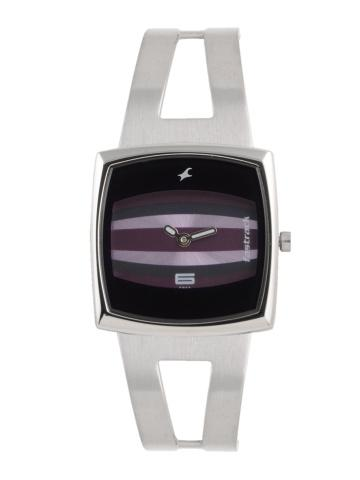

In [55]:
_ = search_text(text='시계')

======= Query ========
None



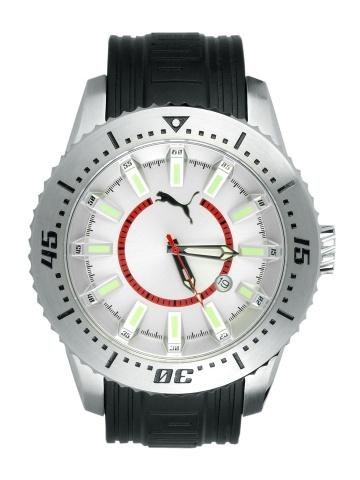

이 이미지에는 스포티한 디자인의 남성 시계가 있습니다. 시계 케이스는 스테인리스 스틸로 제작되었고, 베젤에는 회전 가능한 링이 있어 시간 측정에 유용할 것 같습니다. 시계 문판은 흰색이며 녹색, 빨간색 등의 강렬한 색상 포인터가 있어 가독성이 좋아 보입니다. 시계 밴드는 검은색 고무로 되어 있어 스포츠나 아웃도어 활동 시 착용하기에 적합해 보입니다.
======= Results ========


id,embedType,thumbnail,page_content,score
32350,text-summary,,이 이미지는 스테인리스 스틸 소재의 은색 밴드와 베젤이 있는 아날로그 시계를 보여주고 있습니다. 다이얼은 블랙 컬러이며 아라비아 숫자와 바 인덱스가 있습니다. 베젤에는 회전 베젤이 있어 시간 측정이 가능합니다.,0.726137
23268,text-summary,,이미지는 스테인리스 스틸 소재의 정사각형 남성용 아날로그 시계를 보여주고 있습니다. 다이얼은 블루 컬러이며 로마 숫자와 바늘이 있습니다. 스틸 밴드가 있고 케이스 측면에 나사가 있어 시간 조절이 가능해 보입니다.,0.722584
53589,text-summary,,"이 이미지는 스테인리스 스틸 소재의 원형 케이스와 블랙 다이얼, 화이트 및 블랙 바늘, 그리고 스틸 스트랩으로 구성된 Q&Q 브랜드의 남성용 아날로그 시계를 보여주고 있습니다. 다이얼에는 노란색 액센트가 있어 스포티한 느낌을 더합니다.",0.720821
11639,text-summary,,이 이미지는 검은색 플라스틱 케이스와 고무 스트랩으로 이루어진 디지털 시계를 보여줍니다. 직사각형 모양의 디스플레이에는 녹색 숫자로 시간이 표시되어 있습니다. 전체적으로 스포티하고 실용적인 디자인입니다.,0.702510
26334,text-summary,,"이미지는 스테인리스 스틸 케이스에 블랙 다이얼, 가죽 스트랩이 있는 아날로그 시계를 보여주고 있습니다. 시계 다이얼은 검정색이며 시간과 분 바늘이 있습니다. 스트랩은 검정색 가죽 소재이고 탱 버클로 고정됩니다.",0.698402
29415,text-summary,,"이미지는 블랙 가죽 밴드에 스테인리스 스틸 라운드 케이스, 화이트 다이얼, 로마 숫자 시간 표시가 있는 클래식한 남성 아날로그 시계를 보여줍니다.",0.694440

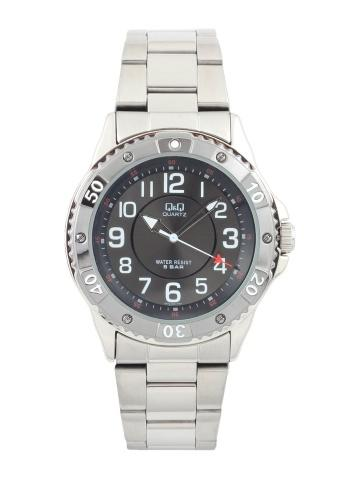
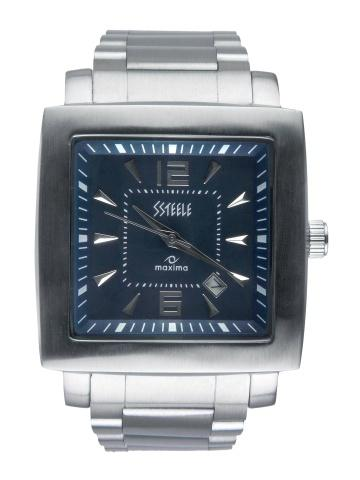
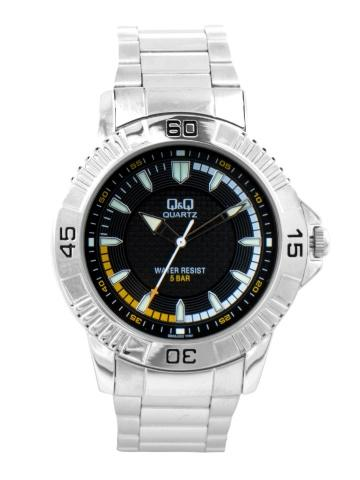
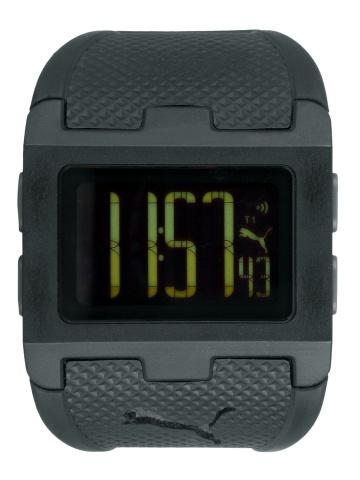
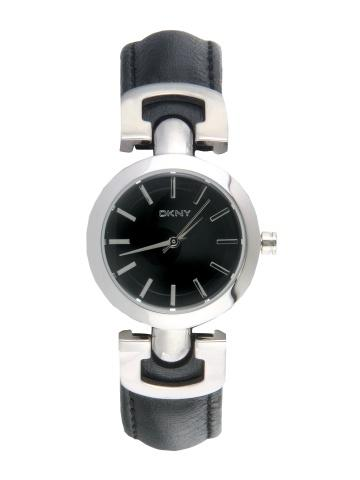
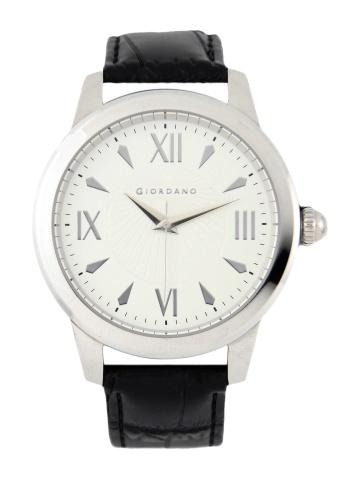

In [56]:
_ = search_text(image=image)

---

### 3. Query가 텍스트인 경우 Text Embedding, 이미지를 포함한 경우 Multimodal Embedding

```mermaid
graph LR
    A[\image\]:::imageStyle
    E[\text\]:::descStyle

    A --> F[[Multimodal Embedding]]:::multiEmbeddingStyle
    E --> G[[Text Embedding]]:::textEmbeddingStyle

    F --> H[(product-image)]:::outputStyle
    G --> I[(product-text)]:::outputStyle

    classDef imageStyle fill:#B090F3,stroke:#E6E6FA,stroke-width:2px,color:#000000;
    classDef descStyle fill:#87CAF0,stroke:#E6E6FA,stroke-width:2px,color:#000000;
    classDef multiEmbeddingStyle fill:#FFA500,stroke:#F08D2B,stroke-width:2px,color:#000000;
    classDef textEmbeddingStyle fill:#FFE451,stroke:#F08D2B,stroke-width:2px,color:#000000;
    classDef outputStyle fill:#F08D2B,stroke:#FFFFFF,stroke-width:2px,color:#000000;
```

======= Query ========
시계
======= Results ========


id,embedType,thumbnail,page_content,score
11639,text-imgdesc,,이 이미지는 검은색 플라스틱 케이스와 고무 스트랩으로 이루어진 디지털 시계를 보여줍니다. 직사각형 모양의 디스플레이에는 녹색 숫자로 시간이 표시되어 있습니다. 전체적으로 스포티하고 실용적인 디자인입니다.,0.575755
43190,text-imgdesc,,이 이미지는 블랙 실리콘 밴드에 화이트 다이얼과 레드 포인터가 있는 스포티한 디자인의 아날로그 쿼츠 시계를 보여줍니다. 다이얼 주변에는 레드 베젤이 있어 시계에 포인트를 더합니다.,0.562858
33887,text,,Citizen Men Black Dial Eco-Drive Watch AW1040-56E 시티즌 남성 블랙 다이얼 에코 드라이브 시계 AW1040-56E 시티즌 남성 에코 드라이브 시계 AW1040-56E - 당신의 스타일을 완성하는 품격 있는 선택 세련된 남성을 위한 시티즌 시계를 소개합니다. 이 시계는 우아한 디자인과 최첨단 기술력을 겸비하여 당신의 스타일을 한층 더 업그레이드시켜 줄 것입니다. 블랙 다이얼과 실버 톤 스테인리스 스틸 브레이슬릿이 조화를 이루어 모던하면서도 클래식한 분위기를 자아냅니다. 날짜 창과 야간에도 잘 보이는 야광 인덱스가 있어 실용성도 높습니다. 가장 주목할 만한 점은 바로 에코 드라이브 기술입니다. 이 기술 덕분에 배터리 교체 없이 영구적으로 작동하므로 번거로움에서 벗어날 수 있습니다. 또한 100m 방수 기능이 있어 활동적인 라이프스타일에도 적합합니다. 품격 있는 디자인과 최신 기술이 결합된 시티즌 시계로 당신의 스타일을 한층 더 높여보세요. 지금 바로 구매하고 특별한 순간을 더욱 특별하게 만들어 보시기 바랍니다.,0.562037
23268,text-imgdesc,,이미지는 스테인리스 스틸 소재의 정사각형 남성용 아날로그 시계를 보여주고 있습니다. 다이얼은 블루 컬러이며 로마 숫자와 바늘이 있습니다. 스틸 밴드가 있고 케이스 측면에 나사가 있어 시간 조절이 가능해 보입니다.,0.560405
53589,text-imgdesc,,"이 이미지는 스테인리스 스틸 소재의 원형 케이스와 블랙 다이얼, 화이트 및 블랙 바늘, 그리고 스틸 스트랩으로 구성된 Q&Q 브랜드의 남성용 아날로그 시계를 보여주고 있습니다. 다이얼에는 노란색 액센트가 있어 스포티한 느낌을 더합니다.",0.558292
33887,text-imgdesc,,"이미지는 스테인리스 스틸 소재의 원형 케이스와 블랙 다이얼, 실버 톤 브레이슬릿 스트랩을 갖춘 아날로그 시계를 보여주고 있습니다. 다이얼에는 시간 표시 마커와 날짜 창이 있으며, 회전 베젤이 있는 스포티한 디자인입니다.",0.557206

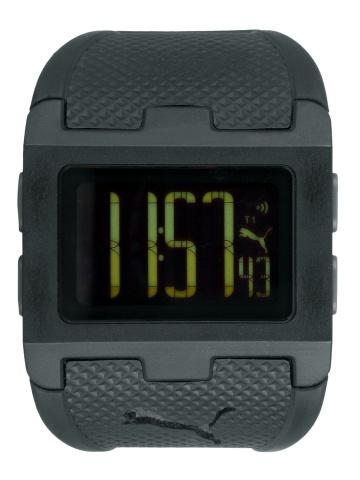
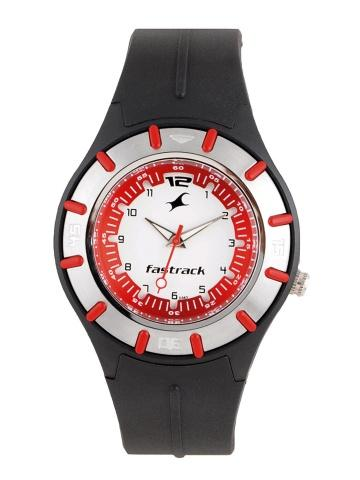
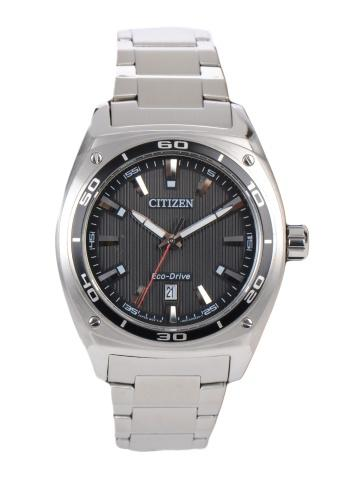
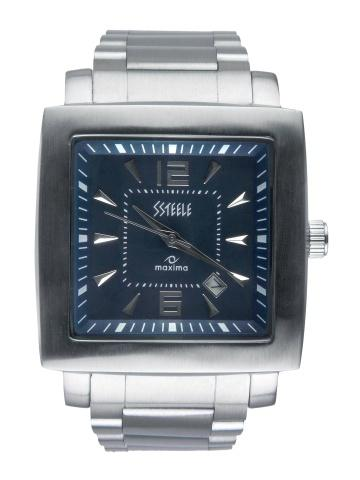
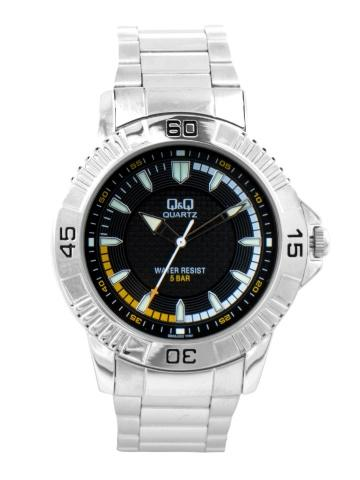
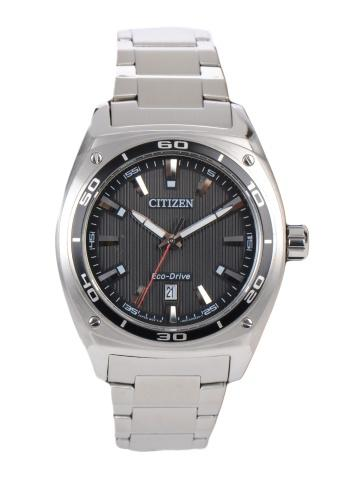

======= Query ========
None



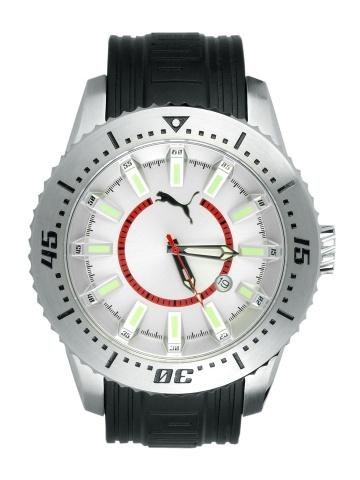

======= Results ========


id,embedType,thumbnail,page_content,score
43190,image,,이 이미지는 블랙 실리콘 밴드에 화이트 다이얼과 레드 포인터가 있는 스포티한 디자인의 아날로그 쿼츠 시계를 보여줍니다. 다이얼 주변에는 레드 베젤이 있어 시계에 포인트를 더합니다.,0.799584
53589,image,,"이 이미지는 스테인리스 스틸 소재의 원형 케이스와 블랙 다이얼, 화이트 및 블랙 바늘, 그리고 스틸 스트랩으로 구성된 Q&Q 브랜드의 남성용 아날로그 시계를 보여주고 있습니다. 다이얼에는 노란색 액센트가 있어 스포티한 느낌을 더합니다.",0.765911
32350,image,,이 이미지는 스테인리스 스틸 소재의 은색 밴드와 베젤이 있는 아날로그 시계를 보여주고 있습니다. 다이얼은 블랙 컬러이며 아라비아 숫자와 바 인덱스가 있습니다. 베젤에는 회전 베젤이 있어 시간 측정이 가능합니다.,0.764429
43190,image-namekor,,패스트랙 여성 화이트 다이얼 시계,0.757479
53589,image-namekor,,Q&Q 남성 블랙 다이얼 시계,0.737743
29415,image,,"이미지는 블랙 가죽 밴드에 스테인리스 스틸 라운드 케이스, 화이트 다이얼, 로마 숫자 시간 표시가 있는 클래식한 남성 아날로그 시계를 보여줍니다.",0.737140

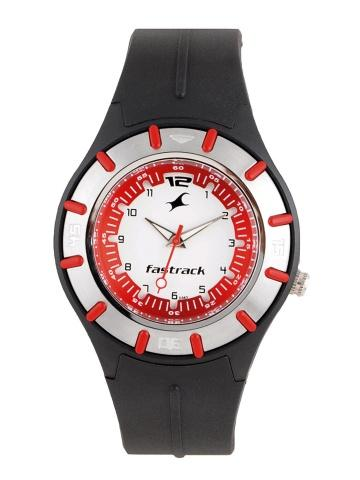
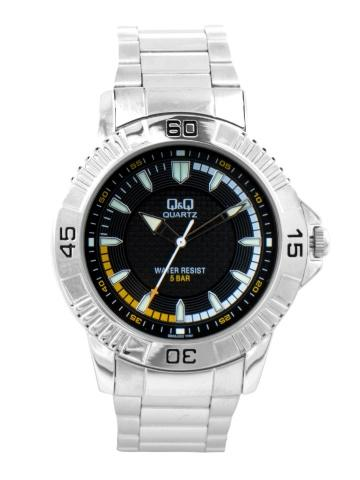
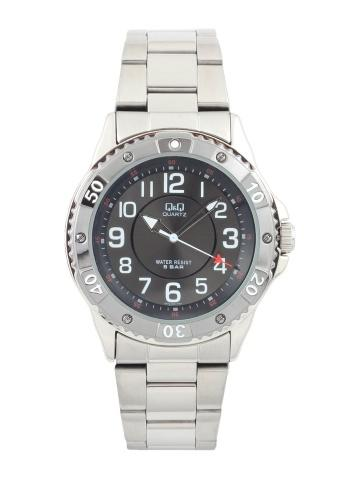
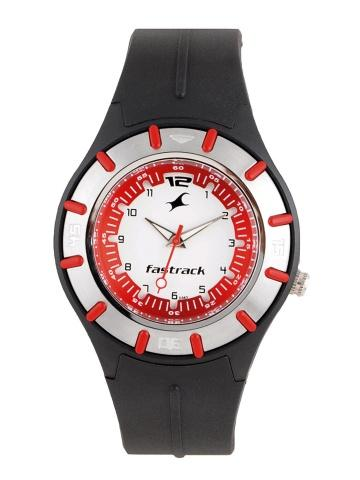
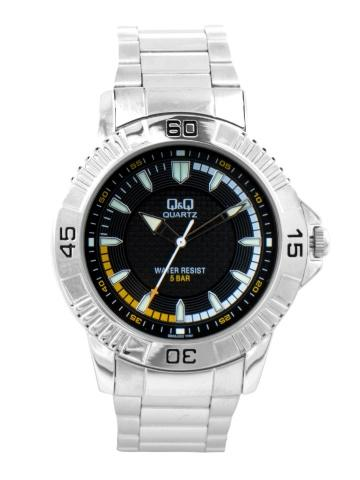
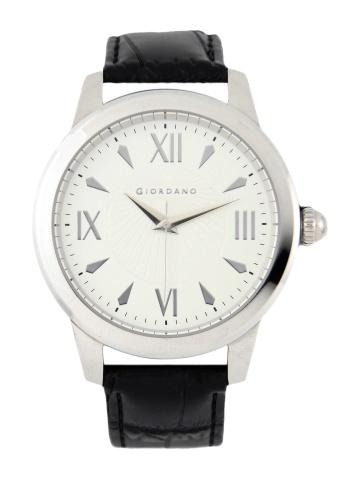

In [9]:
_ = search_hybrid(text='시계')
_ = search_hybrid(image=image)

======= Query ========
None



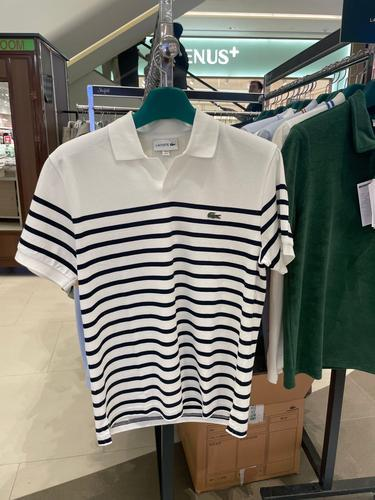

======= Results ========


id,embedType,thumbnail,page_content,score
5719,image-namekor,,베이식스 남성 녹색 아카데미 축구 리그 티셔츠,0.713857
11743,image-namekor,,리 남성 그린 폴로 티셔츠,0.706420
5719,image,,"이미지는 흰색, 녹색, 갈색 줄무늬 패턴의 폴로 셔츠를 착용한 남성 모델을 보여주고 있습니다. 셔츠에는 가슴 부분에 작은 패치 장식이 있고 단추가 달려 있는 폴로 칼라 디자인입니다. 면 소재로 만들어진 캐주얼한 스타일의 여름 티셔츠입니다.",0.699933
19594,image-namekor,,유나이티드 컬러스 오브 베네통 남성 스트라이프 블랙 티셔츠,0.691428
11743,image,,"이미지는 남성 모델이 올리브 그린 색상에 연한 그린 스트라이프 무늬가 있는 반팔 폴로 티셔츠를 입고 있는 모습을 보여줍니다. 티셔츠는 면 소재로 제작되었으며, 폴로 카라와 소매 단에 리브 디테일이 있고 가슴 부분에 브랜드 로고가 새겨져 있습니다.",0.687048
36184,image-namekor,,리드 앤 테일러 남성 그레이 블루 폴로 티셔츠,0.683045

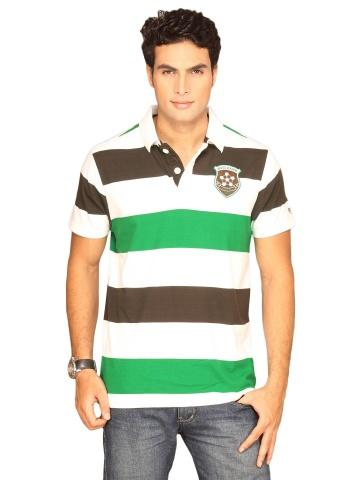
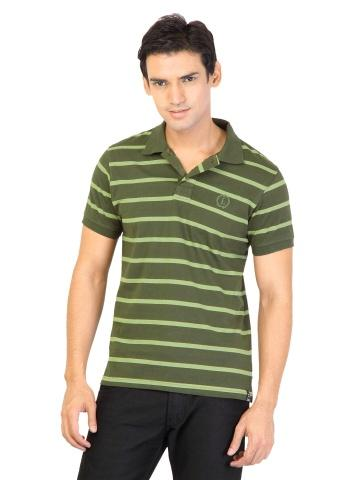
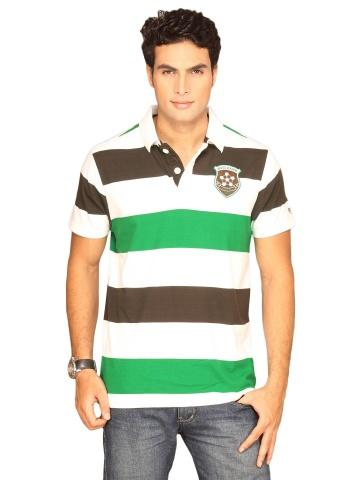
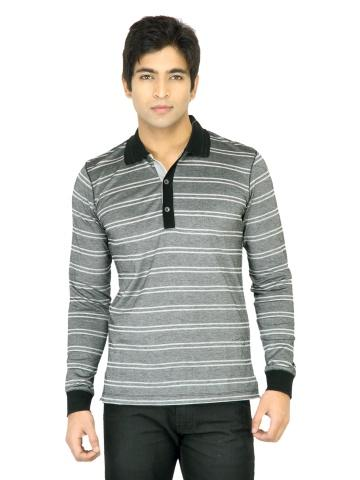
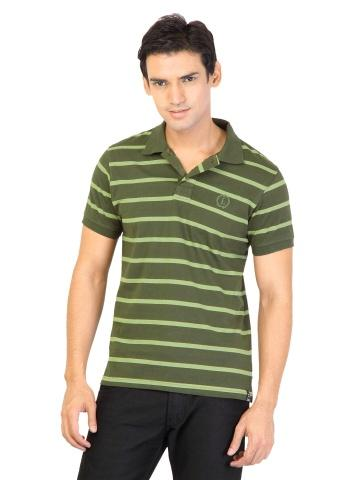
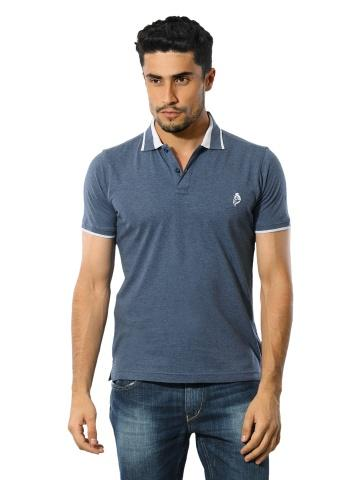

======= Query ========
None



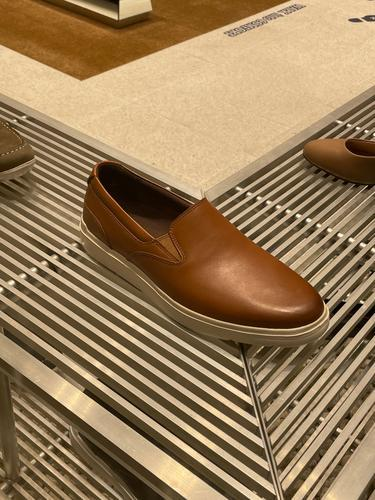

======= Results ========


id,embedType,thumbnail,page_content,score
2890,image-namekor,,캣워크 여성 가죽 브라운 컷 플랫,0.699077
2890,image,,이미지는 브라운 컬러의 가죽 소재 플랫 슈즈를 보여주고 있습니다. 단정한 디자인으로 캐주얼한 스타일에 잘 어울릴 것 같습니다.,0.692155
15671,image-namekor,,하이랜더 남성 하이 오리지널 블루 진,0.676671
15491,image-namekor,,칼튼 런던 여성 누드 하이힐,0.676633
18841,image-namekor,,피터 잉글랜드 남성 정장 탄 벨트,0.676216
10131,image-namekor,,에스프리트 여성 로만 브라운 스틸 시계,0.675768

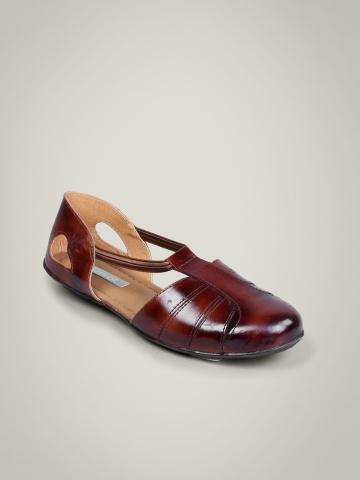
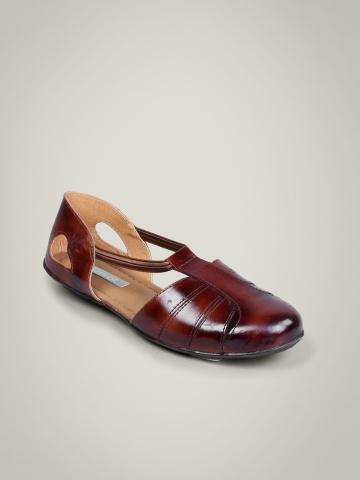
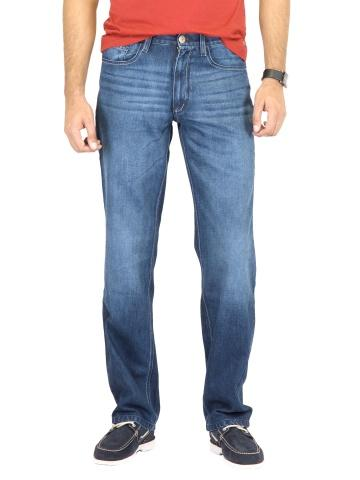
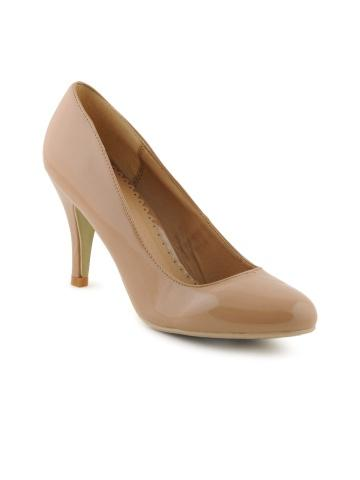
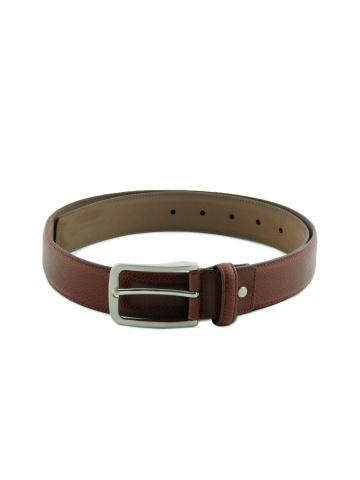
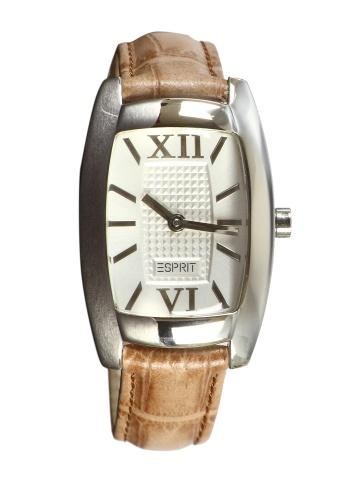

======= Query ========
None



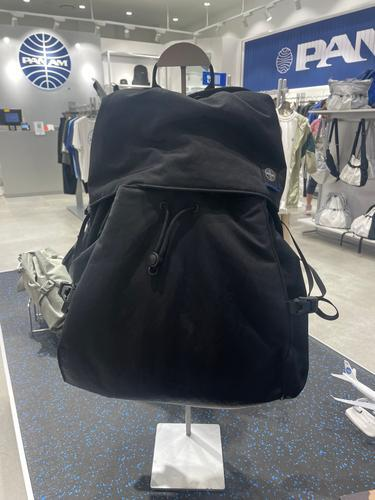

======= Results ========


id,embedType,thumbnail,page_content,score
39520,image-namekor,,피터 잉글랜드 유니섹스 블랙 메신저 가방,0.694735
39520,image,,이 이미지는 검정색 합성 소재로 만들어진 메신저 가방을 보여주고 있습니다. 가방에는 여러 개의 주머니와 지퍼 포켓이 있으며 길고 조절 가능한 어깨 끈이 달려 있습니다. 전체적으로 실용적이고 스타일리시한 디자인입니다.,0.683825
20387,image-namekor,,배깃 여성 버니 타지 퍼플 핸드백,0.679214
16072,image-namekor,,하이랜더 남성 솔리드 블랙 바지,0.667550
28501,image-namekor,,어반 요가 남성 네이비 블루 트랙 팬츠,0.667130
57042,image-namekor,,엘 블랙 드레스,0.666161

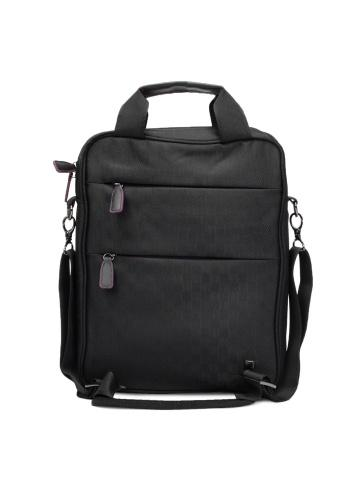
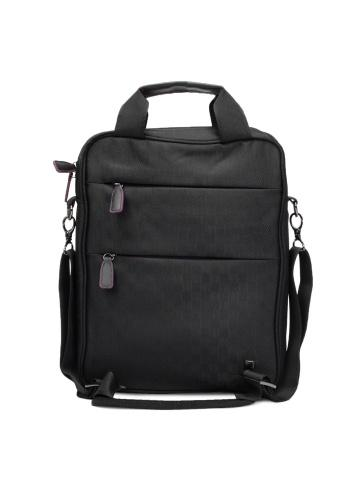
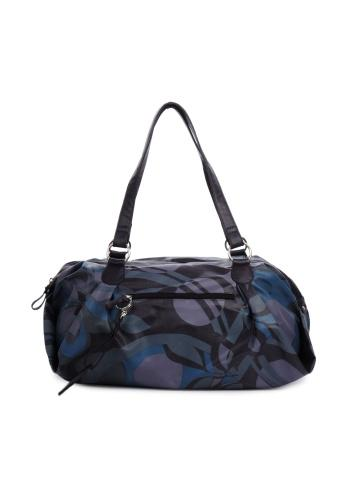
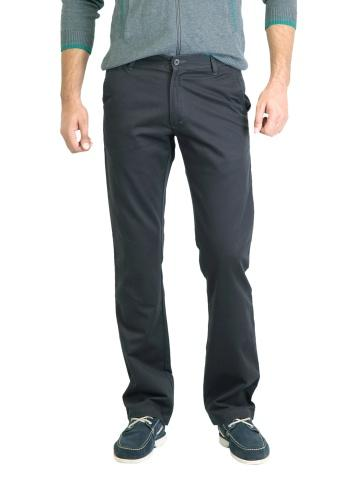
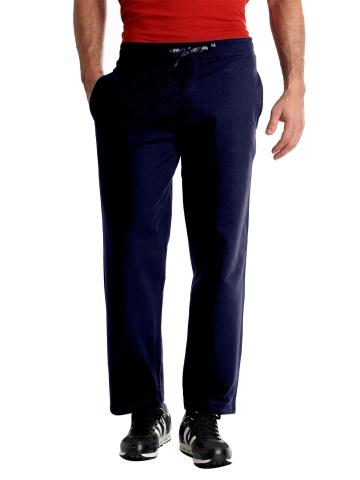
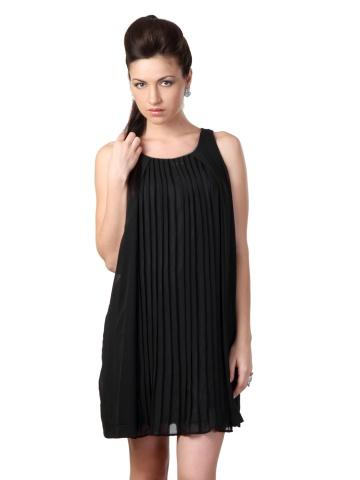

======= Query ========
None



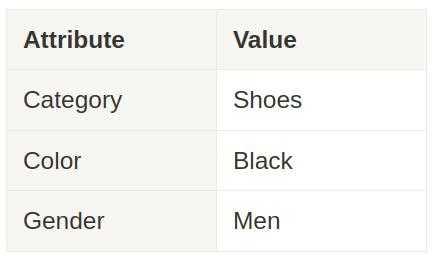

======= Results ========


id,embedType,thumbnail,page_content,score
51605,image-namekor,,크라우스 진스 여성 블랙 바지,0.655733
33983,image-namekor,,페멜라 여성 블랙 스타킹,0.655157
9134,image-namekor,,푸마 남성 이크노이스 2XT 블랙 스포츠 신발,0.649054
4996,image-namekor,,휠라 남성 드리프트 블랙 실버 신발,0.647991
15084,image-namekor,,마더 어스 남성 솔리드 화이트 츄리다르,0.647594
3186,image-namekor,,나이키 남성 메인 드로우 화이트 신발,0.645405

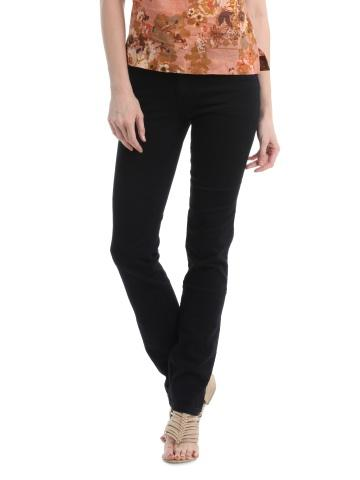
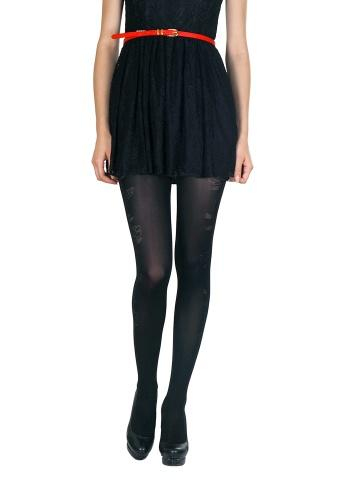
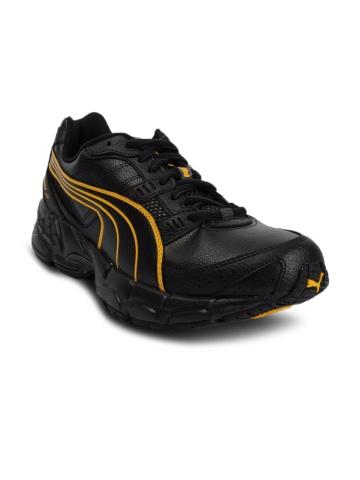
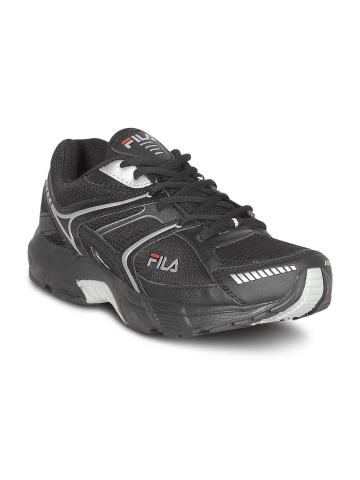
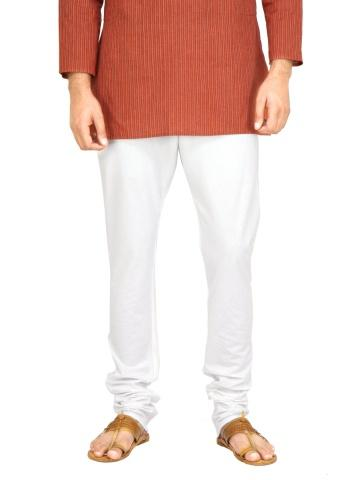
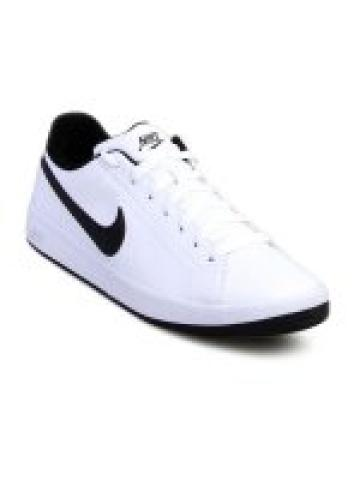

======= Query ========
None



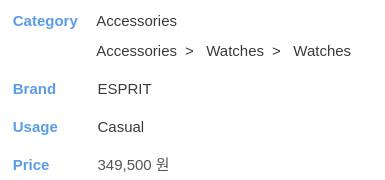

======= Results ========


id,embedType,thumbnail,page_content,score
10131,image-namekor,,에스프리트 여성 로만 브라운 스틸 시계,0.658177
11639,image-namekor,,푸마 남성 플럭스 L 블랙 시계,0.656048
16863,image-namekor,,아이디 여성 펑키 아이웨어 블랙 선글라스,0.647549
23268,image-namekor,,맥시마 스틸 남성 블루 시계,0.644517
43167,image-namekor,,패스트랙 여성 보라색 다이얼 시계,0.644023
33853,image-namekor,,푸마 남성 볼트 호손 헥스 그레이 신발,0.643353

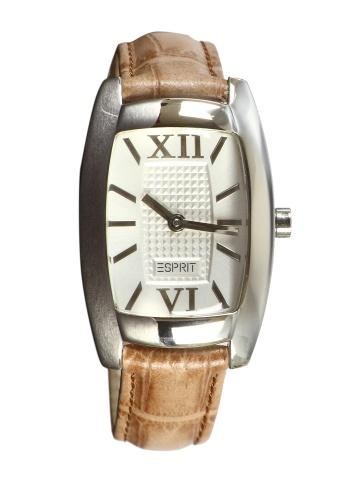
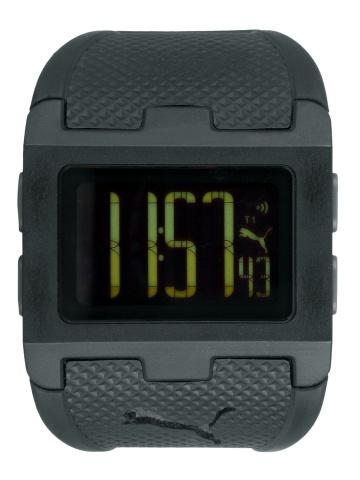
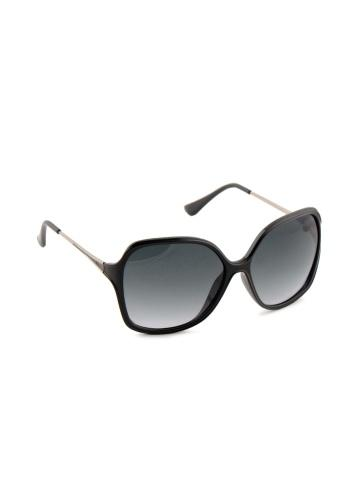
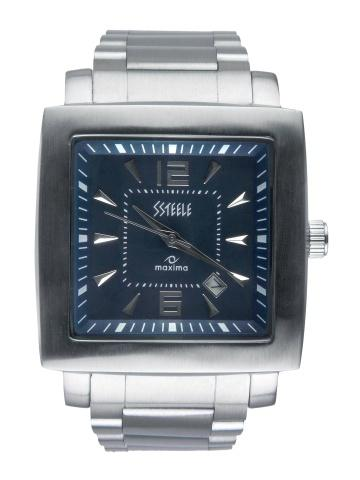
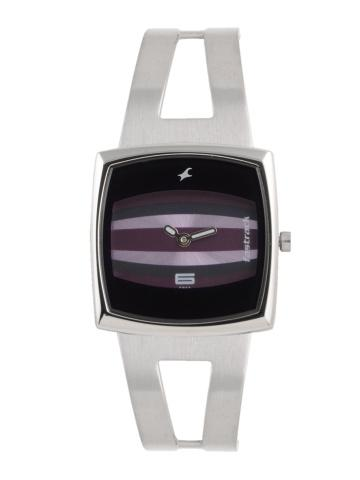
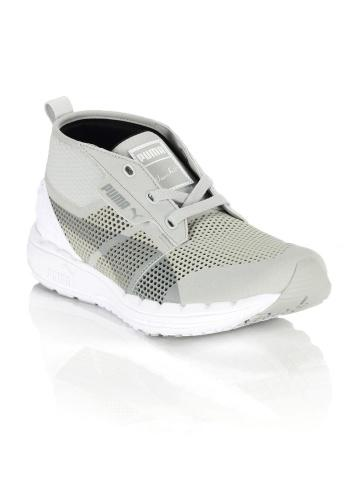

In [11]:
# data/test 폴더 내 이미지 검색
for root, dirs, files in os.walk('../data/test/'):
    for file in files:
        if any(file.lower().endswith(ext) for ext in ['.jpeg', '.jpg', '.png']):
            image = encode_image_base64_from_file(file_path=os.path.join(root, file))
            search_hybrid(image=image)